In [1]:
# SET UP (it will take a long time to run)
using Pkg; Pkg.activate("C:/Users/nicot/GitHub/Tutorial_DynMacro")
using Plots; using Optim; using Interpolations; using LinearAlgebra; using QuantEcon
Pkg.status()

  Activating environment at `C:\Users\nicot\GitHub\Tutorial_DynMacro\Project.toml`

      Status `D:\GitHub\Tutorial_DynMacro\Project.toml`
 

 [31c24e10] Distributions v0.23.11
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.4.1
  [fcd29c91] QuantEcon v0.16.2


In [2]:
# STEP 0: Parameters
P=[0.9565 0.0435; 0.5 0.5 ]  # 𝜖=1 empleado, 𝜖=2 desempleado
γ = 2.0
α = 0.36 
𝛿 = 0.005
β = 0.995
𝜏 = 0.02
a_minp = -2.0 # a_min parameter
rep = 0.25 # new
;

In [5]:
# STEP 1: Computing ss N and defining basic functions
mc = MarkovChain(P)
Pss=stationary_distributions(mc)[1]
@show Nss=Pss[1]

r(K) = α*(Nss/K)^(1-α)-𝛿
w(K) = (1-α)*(Nss/K)^α
b(K) = (1-Nss)*(w(K)*Nss+r(K)*K)*𝜏 # b(K) = w(K)*rep
a_min(K) = max(a_minp,-b(K)/((1-𝜏)*r(K)))
y(a,𝜖,K) = 𝜖==1 ?     a + (1-𝜏)*a*r(K) + (1-𝜏)*w(K) :  a + (1-𝜏)*a*r(K) + b(K)   # 𝜖=1 empleado, 𝜖=2 desempleado
# y(a,𝜖,K) = a + (1-𝜏)*a*r(K) + (2-𝜖)*(1-𝜏)*w(K) + (𝜖-1)*b(K)   # alternative formulation

#u(c) = γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)
#u(c) = c<=0.0 ?  -1.0e10  :  u_crra(c)    # to avoid problems
u(c) = -1/c  # γ = 2

;

Nss = Pss[1] = 0.9199632014719411


In [4]:
# STEP 2: First guess for K
@show K_0 = Nss*((α/(1/β-1+𝛿)))^(1/(1-α))

@show r_0 = r(K_0)
@show w_0 = w(K_0)
@show b_0 = b(K_0)
@show a_min_0 = a_min(K_0)

#y_0(a,𝜖)=y(a,𝜖,K_0);

K_0 = Nss * (α / ((1 / β - 1) + 𝛿)) ^ (1 / (1 - α)) = 247.6225912510229
r_0 = r(K_0) = 0.005025125628140613
w_0 = w(K_0) = 0.08538328174329603
b_0 = b(K_0) = 0.002117588174361281
a_min_0 = a_min(K_0) = -0.4300000476509209


In [19]:
@show 1+(1-𝜏)*r_0
@show b_0

1 + (1 - 𝜏) * r_0 = 1.0049246231155777
b_0 = 0.002117588174361281


0.002117588174361281

In [11]:
# Assume determinist case of always unempoyed guy
yu(a)=y(a,2,K_0) # total income given previous wealth, it is like the production function in previous attemps
Amax=1/(1-r_0*(1-𝜏)) # what if he never eats and only saves?
n_a=201
@show K_grid = range(1e-10, Amax, length=n_a)
@show A_grid = range(a_min_0, Amax, length=n_a)
A_grid2 = range(a_min_0, 3000, length=n_a);


K_grid = range(1.0e-10, Amax, length = n_a) = 1.0e-10:0.005024744974755024:1.0049489950510049
A_grid = range(a_min_0, Amax, length = n_a) = -0.4300000476509209:0.007174745213509629:1.0049489950510049


In [14]:
# Initialization of the value function
V_0(a) = u(yu(a)-a)/(1-β)                       # First guess you eat all your income, you maintain your asset holdings
V_0_K=V_0.(K_grid) # vectorized over K grid (positive values only)
V_0_A=V_0.(A_grid) # vectorized over K grid (negative to positive interval)
;

In [16]:
# Bellman's operator
function T(V, grid)                                                     # takes a vector and a grid (same dimention n)
    V_lin = LinearInterpolation(grid, V, extrapolation_bc = Line())     # linear interpolation
    V_new=fill(0.0,length(grid)); g_new=fill(0.0,length(grid))          # initialize two n dimension vectors   
    objectives = (X -> u.(yu(a)-X) + β * V_lin(X)   for a in grid)    # objective functions (one function for each a in the grid)
    results = maximize.(objectives, A_grid[1]+1e-10, yu.(A_grid).+1e-10)  # maximize every functions objective functions (chooses X)
    V_new = Optim.maximum.(results)                        # returns the maximum value for each function (as many functions as a-values in the grid)
    g_new = Optim.maximizer.(results)                      # returns the maximizer value for each function
    return [V_new, g_new]
end

T (generic function with 1 method)

Number of iterations: 50
Distance between last two value functions: 1.9774217612588457e13


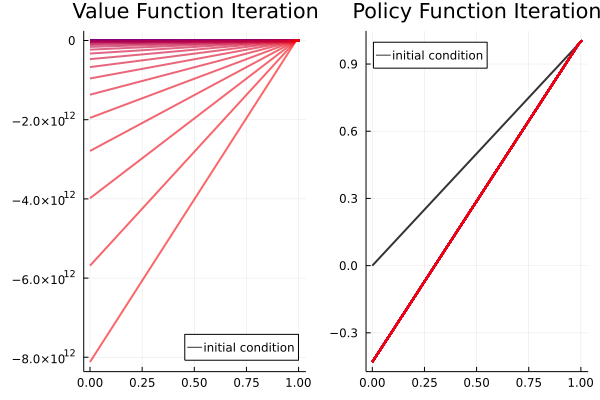

In [18]:
# Using nice positive K_grid

V=V_0.(K_grid) # dicretized form of V_0
g=collect(K_grid) # initial polcy function consisten with V_0 (maintain asset holdings)

pltV=plot(K_grid, V, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(K_grid, g, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

max_iter = 50   
tol = 1e-10 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance
i=1
while i < max_iter && distance > tol
    global V_new, g_new = T(V, K_grid)
    plot!(pltV,K_grid, V_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    plot!(pltg,K_grid, g_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    distance = norm(V_new - V)
    i += 1
    V = V_new  # copy contents into v.  Also could have used v[:] = v_next
end
g=LinearInterpolation(K_grid, g_new, extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)